# **Superconductivity Regression Notebook - Testing Single Models**
Trains models to predict critical temperatures based on features found with "*../code/get_featurizers.ipynb*". Imports data from "*../data/supercon_feat.csv*", which is produced in *get_featurizers.ipynb*. The orginal data is from the supercon database. This notebook is for testing single models.

*Author: Kirk Kleinsasser*

In [ ]:
import dill
#dill.load_session('../data/latest-run.db') #this can load a saved python session so I don't need to rerun computationally expensive cells
%autosave 300 
#autosaves code every five minutes

#identify materials at zero (sample a few from data) - rfr
#also try extra trees

## Import Libraries / Define Import Data Function

In [1]:
#general imports:
import warnings #to suppress grid search warnings
import numpy as np 
import pandas as pd
import lolopy.learners #allows easy uncertainty
import matplotlib.pyplot as plt
import seaborn as sns #heatmaps
import forestci as fci #confidence intervals for RFR - http://contrib.scikit-learn.org/forest-confidence-interval/index.html

#regression models:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.svm import SVR
from xgboost import XGBRegressor

#various ML tools:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, max_error
from skopt import BayesSearchCV #bayesian optimization

#imports custom libraries (shared functions)
import dependancies.shared_functions as sfn 
from dependancies.superlearner import get_superlearner as superlearner

[MLENS] backend: threading


## Linear Regression

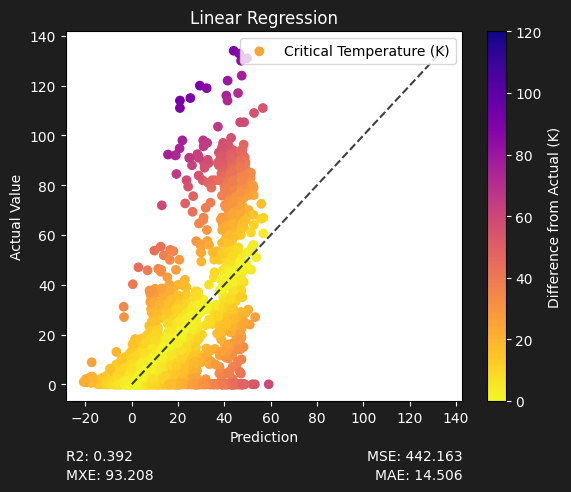

<Figure size 640x480 with 0 Axes>

In [4]:
sfn.import_data(replace_inf=True) #reimport data without infinities

sfn.evaluate_one("Linear Regression", LinearRegression, {})

## Support Vector Regression

In [6]:
sfn.evaluate_one("Support Vector Regression - Linear", SVR, {'kernel':'rbf', 'C':100, 'epsilon':0.1, 'gamma':0.1, 'degree':1})

In [ ]:
sfn.evaluate_one("Support Vector Regression - Nonlinear", SVR, {'C':1, 'epsilon':10, 'gamma':'auto', 'kernel':'linear'})

## Elastic Net Regressor

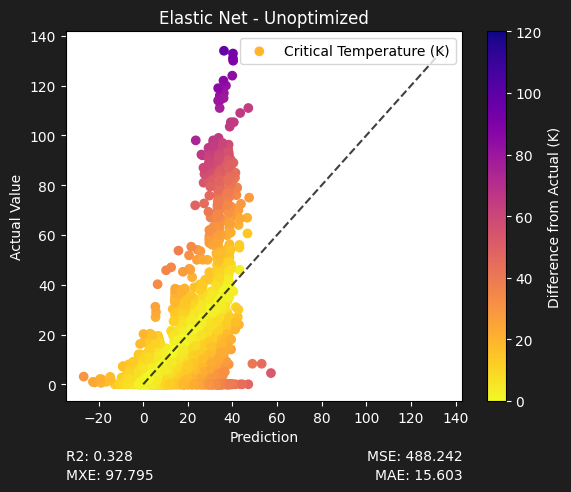

<Figure size 640x480 with 0 Axes>

In [3]:
sfn.evaluate_one("Elastic Net - Unoptimized", ElasticNet, {})

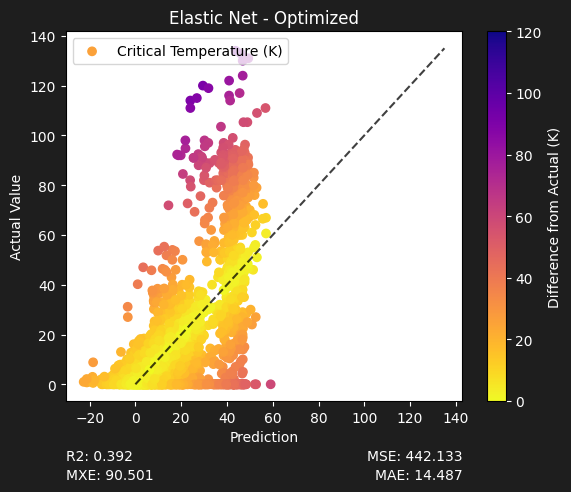

<Figure size 640x480 with 0 Axes>

In [4]:
sfn.evaluate_one("Elastic Net - Optimized", ElasticNet, {'alpha':1e-05, 'l1_ratio':0.0})

## Descision Tree Regressor

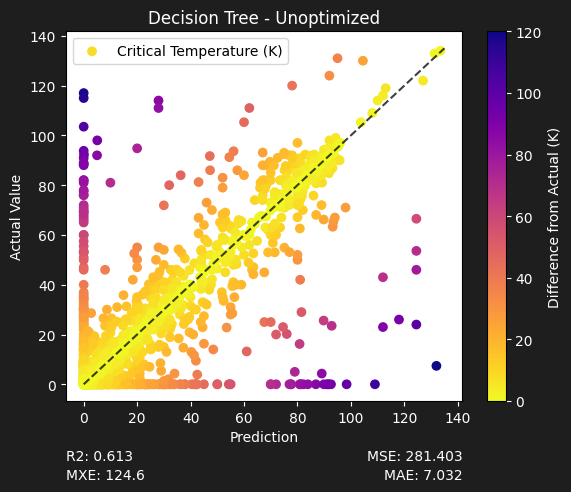

<Figure size 640x480 with 0 Axes>

In [5]:
sfn.evaluate_one("Decision Tree - Unoptimized", DecisionTreeRegressor, {})

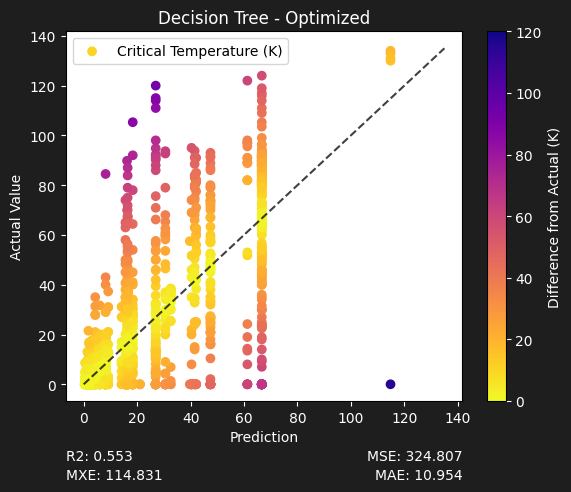

<Figure size 640x480 with 0 Axes>

In [6]:
sfn.evaluate_one("Decision Tree - Optimized", DecisionTreeRegressor, {'criterion':'poisson', 'max_depth':5, 'max_features':0.5})

## Random Forest Regressor

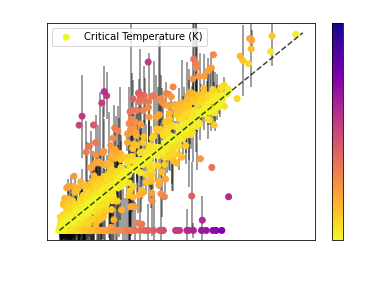

<Figure size 432x288 with 0 Axes>

In [2]:
sfn.import_data(replace_inf=True)
sfn.evaluate_one("Random Forest Regression", RandomForestRegressor, {}, error=True) #NOTE: forestci calibration is disabled as there is a bug in the code (they use a too small datatype)
#compare with lolopy

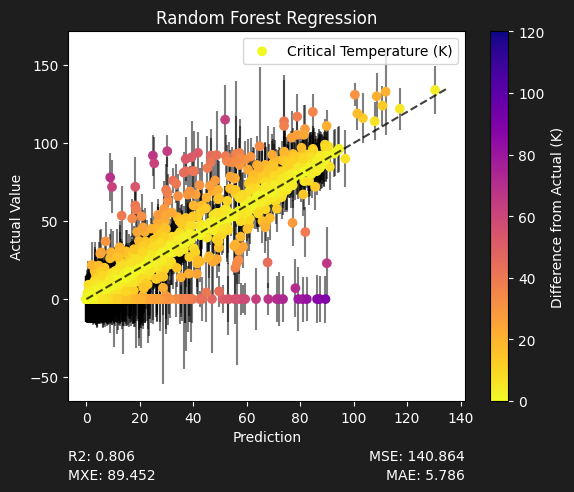

<Figure size 640x480 with 0 Axes>

In [3]:
sfn.import_data(replace_inf=True)
sfn.evaluate_one("Random Forest Regression", RandomForestRegressor, {'max_features': 'auto', 'n_estimators': 300}, error=True)
#compare with lolopy

#identify materials at zero (sample a few from data)

In [ ]:
sfn.import_data(replace_inf=True)
sfn.evaluate_one("Random Forest Regression - Lolopy", lolopy.learners.RandomForestRegressor, {}, error=False)

## KNeighbors Regressor

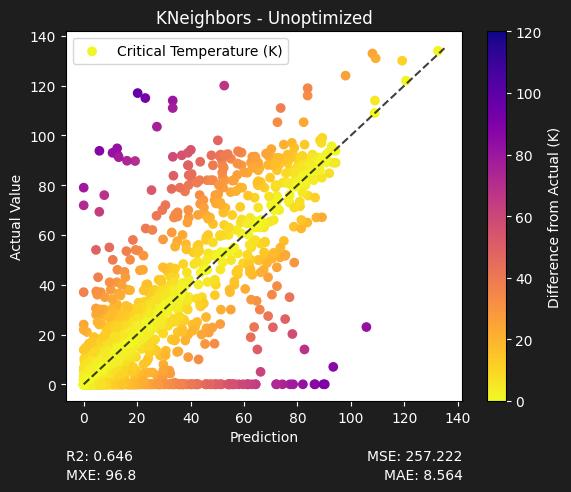

<Figure size 640x480 with 0 Axes>

In [3]:
sfn.evaluate_one("KNeighbors - Unoptimized", KNeighborsRegressor, {})

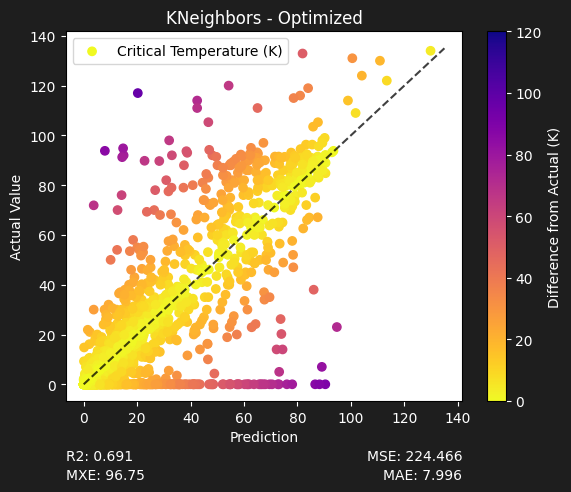

<Figure size 640x480 with 0 Axes>

In [4]:
sfn.evaluate_one("KNeighbors - Optimized", KNeighborsRegressor, {'metric':'manhattan', 'n_jobs':-1, 'n_neighbors':8})

## Extra Trees Regressor

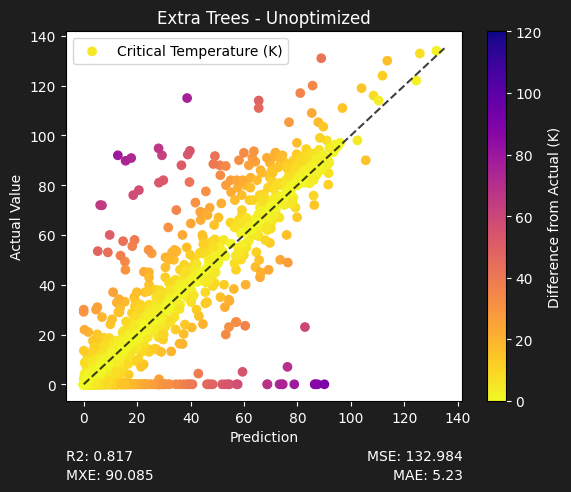

<Figure size 640x480 with 0 Axes>

In [5]:
sfn.evaluate_one("Extra Trees - Unoptimized", ExtraTreesRegressor, {})

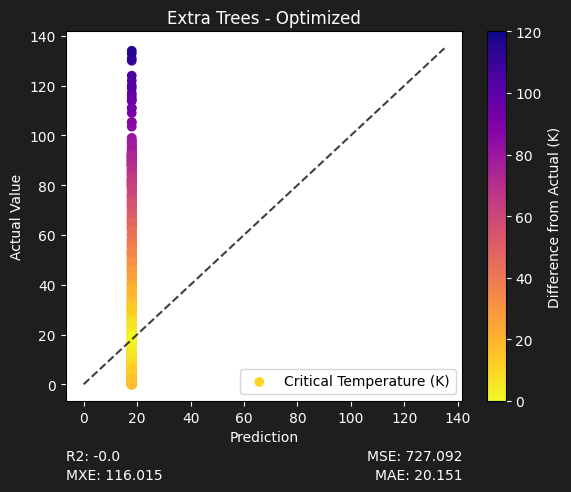

<Figure size 640x480 with 0 Axes>

In [6]:
sfn.evaluate_one("Extra Trees - Optimized", ExtraTreesRegressor, {'min_samples_leaf':1.0, 'min_samples_split':0.1, 'n_estimators':250, 'n_jobs':-1})

## Stochastic Gradient Descent

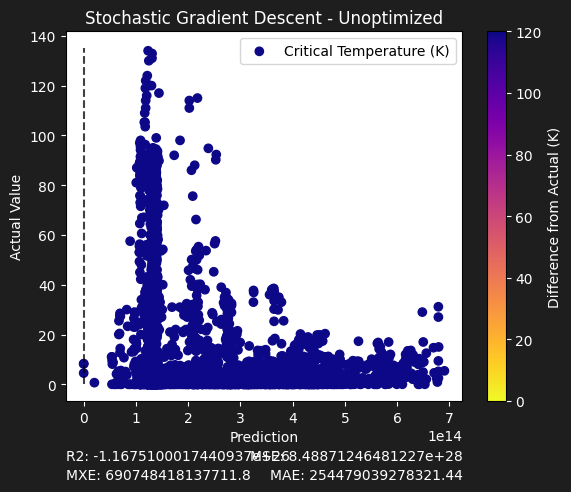

<Figure size 640x480 with 0 Axes>

In [7]:
sfn.evaluate_one("Stochastic Gradient Descent - Unoptimized", SGDRegressor, {})

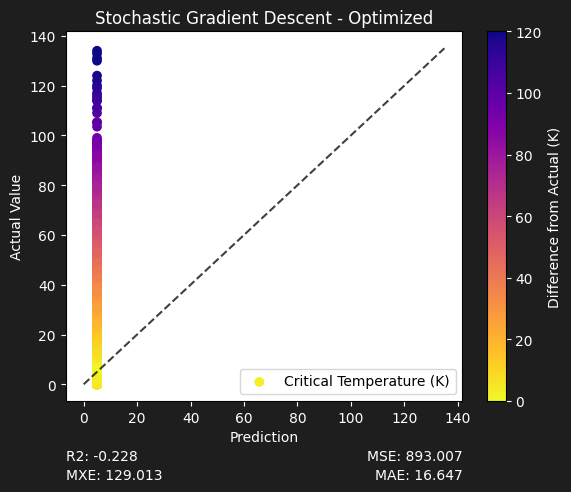

<Figure size 640x480 with 0 Axes>

In [8]:
sfn.evaluate_one("Stochastic Gradient Descent - Optimized", SGDRegressor, {'alpha':1000.0, 'loss':'epsilon_insensitive', 'max_iter':1500, 'penalty':'l1'})

## Bayesian Regression

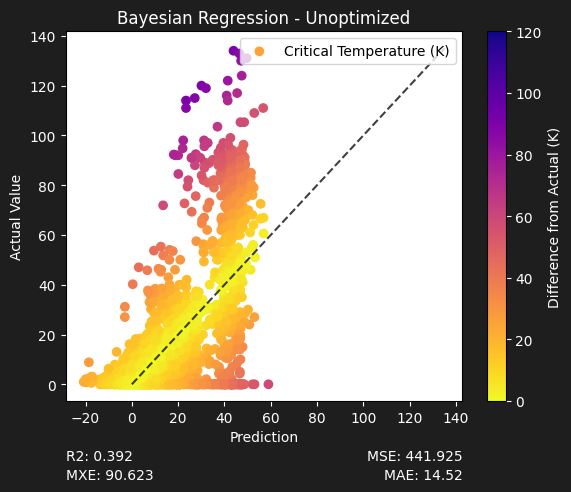

<Figure size 640x480 with 0 Axes>

In [9]:
sfn.evaluate_one("Bayesian Regression - Unoptimized", BayesianRidge, {})

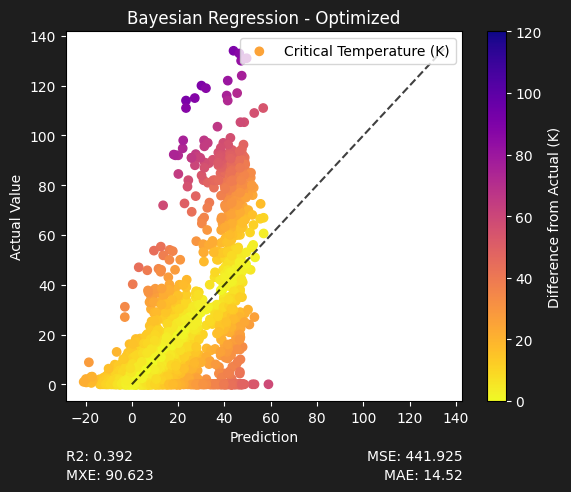

<Figure size 640x480 with 0 Axes>

In [10]:
sfn.evaluate_one("Bayesian Regression - Optimized", BayesianRidge, {'alpha_init':1.2, 'lambda_init':0.0001})

## Superlearner

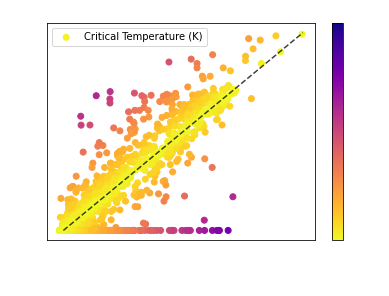

<Figure size 432x288 with 0 Axes>

In [2]:
sfn.import_data(replace_inf=True)

sfn.evaluate_one("Superlearner", superlearner, {'X': sfn.train_data})

In [ ]:
# dill.dump_session('../data/supercon_ml_latest_run.db') #this can dump a python session so I can resume later, after restarts and such